## Telling a Story in Haikus - A Short Data Analysis 

Sometimes you see a dataset so funny or interesting you can't pass it up. News stories from the miserable year that was 2020 converted into haikus by a bunch of people working at Mechanical Turk is one of those datasets. (Check it out here: www.kaggle.com/newshaikus/dataset?c=97d08fc9-dffb-48c1-b8cc-88fd262c641f)

So anyway, we'll upload it, and check out a couple things:

- What's the emotional valence of the haikus?
- What are they about?

And let's have some fun!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import nltk
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer


In [2]:
df = pd.read_json(r"C:\Users\Robert Malka\Desktop\data.json")

with open(r"C:\Users\Robert Malka\Desktop\data.json", "r") as read_file:
    data = json.load(read_file)

In [3]:
df = pd.DataFrame(data)

In [4]:
df.head()

,article-url,content,ts-created,article-url-clean,ts-posted,score,title,description
0,https://www.cbc.ca/news/canada/calgary/rcmp-ja...,one two three four five\nsix seven eight nine ...,2020-02-19T22:13:48Z,cbc.ca/news/canada/calgary/rcmp-jail-cell-stro...,2020-02-17T04:47:37-05:00,47874,"RCMP mistakes stroke victim for drunk, leaving...",An Alberta man's lawsuit says he likely suffer...
1,https://www.reddit.com/r/politics/comments/f6w...,one two three four five\nsix seven eight nine ...,2020-02-20T23:30:24Z,reddit.com/r/politics/comments/f6wlzn/megathre...,2020-02-20T20:41:07-05:00,24747,Megathread: Roger Stone Sentenced to 40 months...,r/politics: /r/Politics is for news and discus...
2,https://www.politico.com/news/2020/02/20/tom-s...,Bloomberg wants wealth tax\nI am not at all we...,2020-02-21T03:08:41Z,politico.com/news/2020/02/20/tom-steyer-mike-b...,2020-02-20T17:06:04-05:00,13074,Steyer: Bloomberg 'sounded like he was running...,The liberal activist called upon his fellow bi...
3,https://www.democracynow.org/2020/2/20/nevada_...,Sanders wants to lead\nHe stands for many peop...,2020-02-21T03:23:00Z,democracynow.org/2020/2/20/nevada_democratic_d...,2020-02-20T19:09:37-05:00,29214,Bernie Sanders Says “Will of the People” Shoul...,As the primary season heads into the Nevada ca...
4,https://taskandpurpose.com/syria-weapons-isis-...,weapons are missing\nthe Pentagon is to blame\...,2020-02-21T04:02:15Z,taskandpurpose.com/syria-weapons-isis-pentagon...,2020-02-20T00:51:48-05:00,40227,The Pentagon lost track of $715 million in wea...,The U.S. government failed to effectively acco...


In [5]:
df.info()
#2900 entries - good to know. Looking at full title/description/content...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   article-url        2900 non-null   object
 1   content            2900 non-null   object
 2   ts-created         2900 non-null   object
 3   article-url-clean  2900 non-null   object
 4   ts-posted          2900 non-null   object
 5   score              2900 non-null   int64 
 6   title              2899 non-null   object
 7   description        2899 non-null   object
dtypes: int64(1), object(7)
memory usage: 181.4+ KB


In [6]:
df['ts-posted'] = pd.to_datetime(df['ts-posted'])
df['ts-posted'] = print(df['ts-posted'].apply(lambda x: x.strftime('%Y-%m-%d')))

0       2020-02-17
1       2020-02-20
2       2020-02-20
3       2020-02-20
4       2020-02-20
           ...    
2895    2020-12-31
2896    2020-12-31
2897    2020-12-31
2898    2020-12-30
2899    2020-12-31
Name: ts-posted, Length: 2900, dtype: object


In [7]:
df['title'][3]

'Bernie Sanders Says “Will of the People” Should Decide Democratic Nomination, Not Party Insiders | Democracy Now!'

In [8]:
df['description'][3]

'As the primary season heads into the Nevada caucuses on Saturday, we unpack the ninth Democratic presidential debate in a roundtable on the tensions at work on the Las Vegas debate stage. Senator Bernie Sanders, currently the front-runner in the race, said the candidate with the most delegates should become the nominee; all his rivals on stage suggested they would be open to a brokered convention, with superdelegates and other party insiders potentially deciding the nomination. We continue our discussion with Katrina vanden Heuvel, editorial director and publisher of The Nation; Raquel Willis, journalist, activist and executive editor of Out magazine; Ana María Archila, co-executive director of the Center for Popular Democracy; and Annise Parker, former mayor of Houston and president of the Victory Fund.'

In [9]:
df['content'][3]

'Sanders wants to lead\nHe stands for many people\nBut can he beat Trump?'

So 'title' is the ordinary headline, 'description' is the blurb attached to that headline, and 'content' is our Haiku. So we'll change 'content' to Haiku...

In [10]:
df = df.rename(columns={'content' : 'haikus'})

...and drop the URLs & the date the article was created.

In [11]:
df = df.drop(['article-url', 'ts-created', 'article-url-clean'], axis=1)

In [12]:
#sort by values.

df = df.sort_values(by='score', ascending=False)

In [13]:
df.head(10)

,haikus,ts-posted,score,title,description
2317,Both sides claim they cheat\nBefore done count...,None,335143,Joe Biden elected president of the United States,WASHINGTON (AP) — Joe Biden elected president ...
2013,A few hundred bucks\nAll Trump paid in income ...,None,147139,NY Times: Trump paid $750 in US income taxes i...,President Donald Trump paid just $750 in feder...
2111,Service to country\nCoronavirus front man\nEmp...,None,144169,Dr. Fauci Named Federal Employee of the Year,"Dr. Anthony S. Fauci, M.D., director of the Na..."
798,Just one more thing eye\ncan't quite control m...,None,132547,Coronavirus in NC - April 27 updates :: WRAL.com,Here are the latest updates on the impact of t...
1572,Kanye West cheated\non presidential campaign\n...,None,130980,Kanye West Removed From Illinois Ballot Over I...,Kanye West's hopes of getting on presidential ...
1433,The feds caused ruckus\nBut their withdrawal b...,None,127937,Portland sees peaceful night of protests follo...,Thursday night’s protest passed off without ma...
2199,To kill Joe Biden\nA North Carolina man\nDisco...,None,126675,North Carolina man arrested after he’s discove...,Alexander Hillel Treisman was arrested in late...
1267,License the police.\nHairdressers and doctors ...,None,125324,Illinois Attorney General Kwame Raoul: License...,"Five years ago, Kwame Raoul helped pass police..."
2355,way too close a call\npenn sliding in to safet...,None,121748,Biden's Pennsylvania lead is now big enough to...,"Official site of The Week Magazine, offering c..."
221,U.S. Supreme Court\nUpholds resident complaint...,None,118953,\n U.S. Supreme Court lets Flin...,The U.S. Supreme Court on Tuesday let resident...


In [14]:
def replace(haiku):
    for text in haiku:
        text.replace("[\n]", " ")
        
replace(df['haikus'])

In [15]:
df['haikus'].replace(r"[\n]", " ")

2317    Both sides claim they cheat\nBefore done count...
2013    A few hundred bucks\nAll Trump paid in income ...
2111    Service to country\nCoronavirus front man\nEmp...
798     Just one more thing eye\ncan't quite control m...
1572    Kanye West cheated\non presidential campaign\n...
                              ...                        
1313    NRA lost staff\ndue to financial trouble\nless...
1782    Trump is the fake news\nFacebook please try an...
1592    prisoners can vote\nin Washington DC soon\ngoo...
1123    I am just in shock\nPress freedom under attack...
549     Stimulus absent\nPostal Service in trouble\nMa...
Name: haikus, Length: 2900, dtype: object

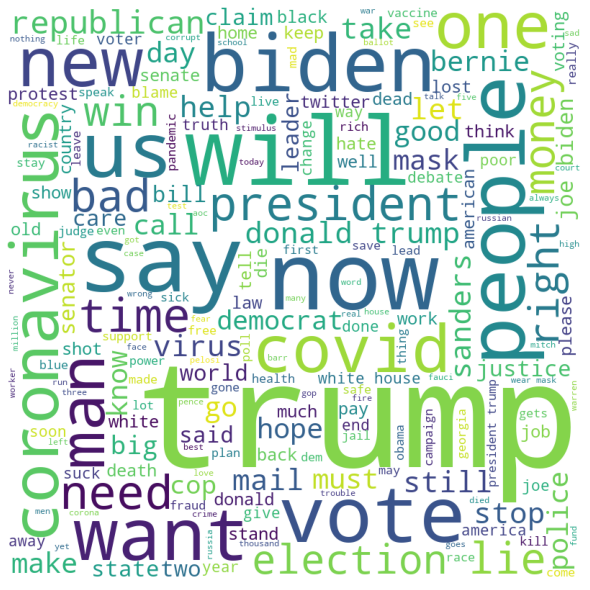

In [16]:
#wordcloud for the Haikus.

comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.haikus: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

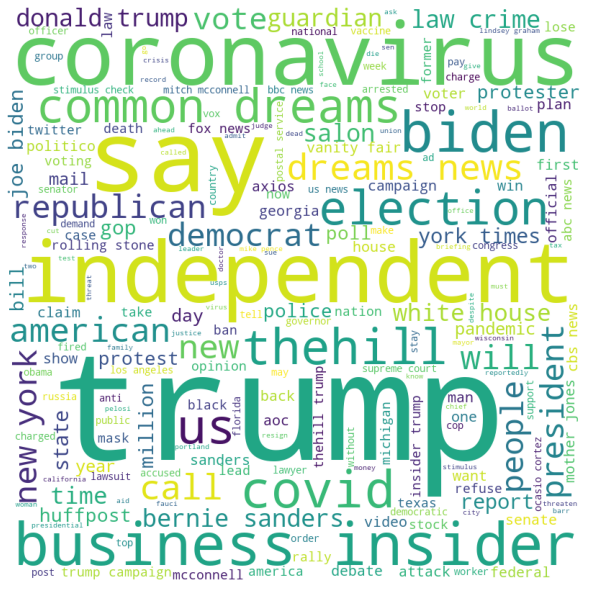

In [17]:
# vs wordcloud for the headlines (titles).

comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.title: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

So the haikus actually seem more negative (perhaps more to-the-point?) than the headlines do - and it's no surprise that they both agree that trump was the epicenter of the media's attention in 2020. Ditto for COVID/Coronavirus. Especially notable is that there's no mention of BLM (though we see "protest" in the headlines), no mention of the massive wealth transfer, big tech censorship, and lots of other events -- this is the result of which news articles they decided to emphasize.

Let's investigate the emotional valence of these haikus.

In [18]:
sid = SentimentIntensityAnalyzer()

def sidscore(haiku):
    
    haikus_valence = []
    
    for i in haiku:
        haikus_valence.append(sid.polarity_scores(i))
                             
    return haikus_valence

In [19]:
#Concatenating the valences with the overall dataset so they all become features. We get four:
# - Neg, or the proportion of negative sentiment in the sentence
# - Pos, or the proportion of positive sentiment in the sentence
# - Neu, or the proportion of neutral sentiment in the sentence
# - Compound, a weighted combination of all of the above

new_var = sidscore(df['haikus'])
new_var = pd.DataFrame(new_var)

In [20]:
df = pd.concat([df, new_var], axis=1)

In [21]:
df.head()

,haikus,ts-posted,score,title,description,neg,neu,pos,compound
0,one two three four five\nsix seven eight nine ...,None,47874,"RCMP mistakes stroke victim for drunk, leaving...",An Alberta man's lawsuit says he likely suffer...,0.172,0.632,0.195,0.1027
1,one two three four five\nsix seven eight nine ...,None,24747,Megathread: Roger Stone Sentenced to 40 months...,r/politics: /r/Politics is for news and discus...,0.241,0.759,0.000,-0.5423
2,Bloomberg wants wealth tax\nI am not at all we...,None,13074,Steyer: Bloomberg 'sounded like he was running...,The liberal activist called upon his fellow bi...,0.000,1.000,0.000,0.0000
3,Sanders wants to lead\nHe stands for many peop...,None,29214,Bernie Sanders Says “Will of the People” Shoul...,As the primary season heads into the Nevada ca...,0.000,0.909,0.091,0.0772
4,weapons are missing\nthe Pentagon is to blame\...,None,40227,The Pentagon lost track of $715 million in wea...,The U.S. government failed to effectively acco...,0.292,0.708,0.000,-0.5106


Text(0.5, 1.0, 'Compound')

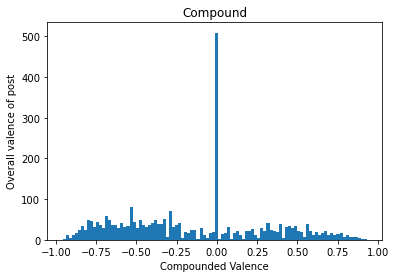

In [22]:
plt.hist(df['compound'], bins=100);
plt.xlabel('Compounded Valence')
plt.ylabel('Overall valence of post')
plt.title('Compound')

#So as expected, the haikus are more negative than positive, with ~1/6 of haikus with "neutral" valence.

Text(0.5, 1.0, 'Overall valence of posts, negative tail')

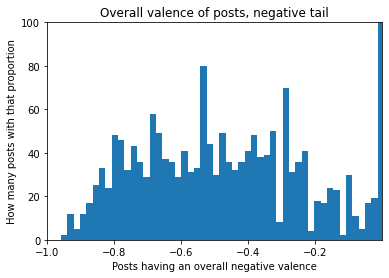

In [23]:
#Let's zoom into the negative side.

plt.hist(df['compound'], bins=100);
plt.xlim(-1, -0.001)
plt.ylim(0, 100)
plt.xlabel('Posts having an overall negative valence')
plt.ylabel('How many posts with that proportion')
plt.title('Overall valence of posts, negative tail')

#No apparent pattern -- there are plenty of highly negative posts. Let's check them out to get an example.

In [24]:
#sort by values.

df = df.sort_values(by='compound', ascending=False)

In [25]:
df.head(-10)

,haikus,ts-posted,score,title,description,neg,neu,pos,compound
1781,"Trump at grave visit\nSays to John, who lost h...",None,10480,Trump questioned Kelly's son's sacrifice on Me...,"President Donald Trump ""can't fathom the idea ...",0.000,0.335,0.665,0.9312
1531,News at eleven\nanother un-masked man fails \n...,None,33112,\n Store worker pepper sprays c...,The customer allegedly got irate and started r...,0.000,0.433,0.567,0.9201
2686,Ben Gibson lost race\nQ-Anon fan now faces\nCh...,None,21533,QAnon-Supporting GOP Candidate Arrested For Ch...,A failed congressional candidate who gave supp...,0.000,0.383,0.617,0.9062
2682,fox just took a poll\nmajority feel we are\nwo...,None,15911,Fox News poll: Majority say US worse off than ...,A Fox News poll released Friday found mixed re...,0.000,0.365,0.635,0.9041
1005,Man charged with murder\nSays he was just film...,None,70642,BREAKING: Man who filmed Ahmaud Arbery video c...,"William&nbsp;&ldquo;Roddie&rdquo; Bryan, who s...",0.000,0.341,0.659,0.8910
...,...,...,...,...,...,...,...,...,...
461,Governors angry\nTrump cannot handle crisis\nM...,None,18731,\n ‘You wasted precious months when you c...,President Donald Trump on Sunday morning raile...,0.559,0.441,0.000,-0.9136
2655,Republican lies\nTears the Lady's dress apart\...,None,17211,Trump voters don't really believe Biden stole ...,Conservatives aren't entirely delusional — the...,0.670,0.330,0.000,-0.9217
2672,Jon and Raphael\nGeorgia here we come to say\n...,None,14938,'Elf' cast reunites to fundraise for Democrats...,"The cast of the 2003 Christmas film ""Elf"" will...",0.604,0.396,0.000,-0.9217
1073,Texas might vote blue\nwas once inconceivable ...,None,33844,Joe Biden tells Texas Democrats they could fli...,Biden addressed the Texas Democratic Party’s o...,0.506,0.494,0.000,-0.9231


So these next five are ostensibly the most negative posts the sentiment analyzer found - let's check them out:

In [26]:
df['haikus'][578]

#Okay, that's a pretty negative one. We see the analyzer takes "liar" and accusations to be very negative.

'Oh, Trump you liar\nYou said we were out of stuff\nWhat are you hiding?'

In [27]:
df['haikus'][1073]

#I don't see how this is negative.

"Texas might vote blue\nwas once inconceivable \nnow it's possible "

In [28]:
df['haikus'][2672]

#That... seems very positive actually. Not an accurate assessment.

"Jon and Raphael\nGeorgia here we come to say\nLet's raise some money"

In [29]:
df['haikus'][2655]

#Hugely negative, well earned position on the list.

"Republican lies\nTears the Lady's dress apart\nNo honor, no hope"

In [30]:
df['haikus'][461]

#Ditto for this one.

'Governors angry\nTrump cannot handle crisis\nMore people will die'

And these next five are supposed to be very positive - let's see if that's true:

In [31]:
df['haikus'][1005]

#If this is more positive than Texas voting blue we've got a real conservative analyzer here.

'Man charged with murder\nSays he was just filming it\nNot really involved'

In [32]:
df['haikus'][2682]

#Might be on the positive side because "\n" is preventing the algorithm from seeing 'worse'??

'fox just took a poll\nmajority feel we are\nworse off from four years'

In [33]:
df['haikus'][2686]

#Okay, doesn't ANYTHING with child porn in it make it negative??

'Ben Gibson lost race\nQ-Anon fan now faces\nCharges for child porn'

In [34]:
df['haikus'][1531]

#The headline about an irate customer pepper-spraying people is more clearly negative than this haiku.
#Kudos, algorithm. Kudos.

'News at eleven\nanother un-masked man fails \nto locate the thread'

In [35]:
df['haikus'][1781]

#There is a strange comedy to this one, so I suppose it quietly deserves a positive mention.

'Trump at grave visit\nSays to John, who lost his son\n" What\'s in it from them? "'

In spite of the doom and gloom of 2020, some clear incidental comedies. Great!